In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'WCH.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,1232,-996,237,119,448,750,744,2303,0,...,365,0,293,1295,1300,4957,194,0,49.0,2014-11-04
1,2014-12-31,1195,-986,209,-17,326,684,734,2093,0,...,375,0,263,1165,1318,5025,33,0,49.0,2015-03-01
2,2015-03-31,1335,-1043,292,71,251,827,795,2150,0,...,433,0,226,1288,1357,5641,163,0,49.0,2015-05-05
3,2015-06-30,1371,-1073,298,108,411,791,783,2249,0,...,432,0,254,1185,1336,4964,140,0,49.0,2015-08-04
4,2015-09-30,1358,-1059,299,58,259,787,783,2128,0,...,390,0,141,1090,1306,4796,189,0,49.0,2015-11-04


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-11-04,49.70,1523,-1325,198,34,935,879,1455,...,308,8812,754,0,443,1692,1095,4071,275,-147
37,2023-12-31,2024-02-29,49.70,1382,-1152,230,27,1013,788,1449,...,293,8854,879,0,418,1763,1088,4275,309,-221
38,2024-03-31,2024-04-22,54.39,1489,-1278,211,48,965,912,1502,...,297,9020,858,0,437,1786,1124,4305,56,-195
39,2024-06-30,2024-07-22,49.70,1468,-1244,224,35,861,894,1594,...,301,9020,852,0,220,1493,1579,4400,-52,-118
40,2024-09-30,2024-10-28,49.70,1430,-1217,213,34,799,855,1672,...,293,8941,797,0,224,1448,1571,4355,48,-146


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-04,49.70,1523,-1325,198,34,935,879,1455,...,8812,754,0,443,1692,1095,4071,275,-147,0.918837
37,2023-12-31,2024-02-29,49.70,1382,-1152,230,27,1013,788,1449,...,8854,879,0,418,1763,1088,4275,309,-221,0.929674
38,2024-03-31,2024-04-22,54.39,1489,-1278,211,48,965,912,1502,...,9020,858,0,437,1786,1124,4305,56,-195,0.920544
39,2024-06-30,2024-07-22,49.70,1468,-1244,224,35,861,894,1594,...,9020,852,0,220,1493,1579,4400,-52,-118,0.928647
40,2024-09-30,2024-10-28,49.70,1430,-1217,213,34,799,855,1672,...,8941,797,0,224,1448,1571,4355,48,-146,0.910617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-04,49.70,1523,-1325,198,34,935,879,1455,...,8812,754,0,443,1692,1095,4071,275,-147,0.918837
37,2023-12-31,2024-02-29,49.70,1382,-1152,230,27,1013,788,1449,...,8854,879,0,418,1763,1088,4275,309,-221,0.929674
38,2024-03-31,2024-04-22,54.39,1489,-1278,211,48,965,912,1502,...,9020,858,0,437,1786,1124,4305,56,-195,0.920544
39,2024-06-30,2024-07-22,49.70,1468,-1244,224,35,861,894,1594,...,9020,852,0,220,1493,1579,4400,-52,-118,0.928647
40,2024-09-30,2024-10-28,49.70,1430,-1217,213,34,799,855,1672,...,8941,797,0,224,1448,1571,4355,48,-146,0.910617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-10,68.973183,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.29648,0.70352,0.0,0.0,0.0,0.0,0.19237,0.096591,0.0,0.0
1,2014-11-17,70.209175,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.29648,0.70352,0.0,0.0,0.0,0.0,0.19237,0.096591,0.0,0.0
2,2014-11-24,68.117508,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.29648,0.70352,0.0,0.0,0.0,0.0,0.19237,0.096591,0.0,0.0
3,2014-12-01,69.368111,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.29648,0.70352,0.0,0.0,0.0,0.0,0.19237,0.096591,0.0,0.0
4,2014-12-08,68.227226,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.29648,0.70352,0.0,0.0,0.0,0.0,0.19237,0.096591,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-10,68.973183,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.0,0.19237,0.096591,0.0,0.0,inf,1.617849,inf,inf,inf
1,2014-11-17,70.209175,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.0,0.19237,0.096591,0.0,0.0,inf,1.646840,inf,inf,inf
2,2014-11-24,68.117508,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.0,0.19237,0.096591,0.0,0.0,inf,1.597778,inf,inf,inf
3,2014-12-01,69.368111,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.0,0.19237,0.096591,0.0,0.0,inf,1.627112,inf,inf,inf
4,2014-12-08,68.227226,2014-09-30,1232.0,0.0,42.632653,49.0,0.0,0.0,448.0,...,0.0,0.19237,0.096591,0.0,0.0,inf,1.600351,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

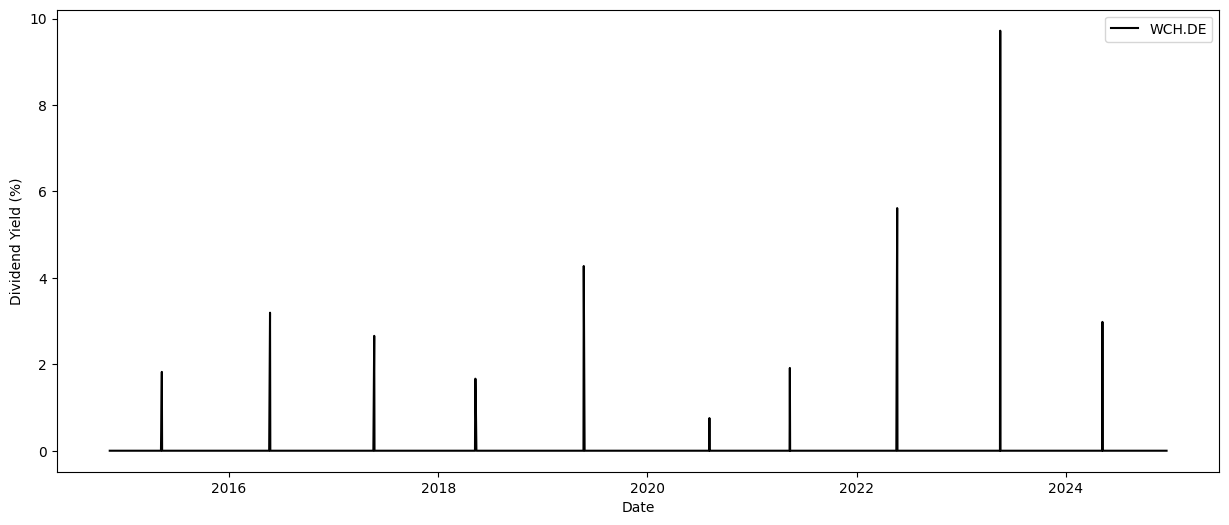

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.051564
share_price      1.000000
Name: share_price, dtype: float64


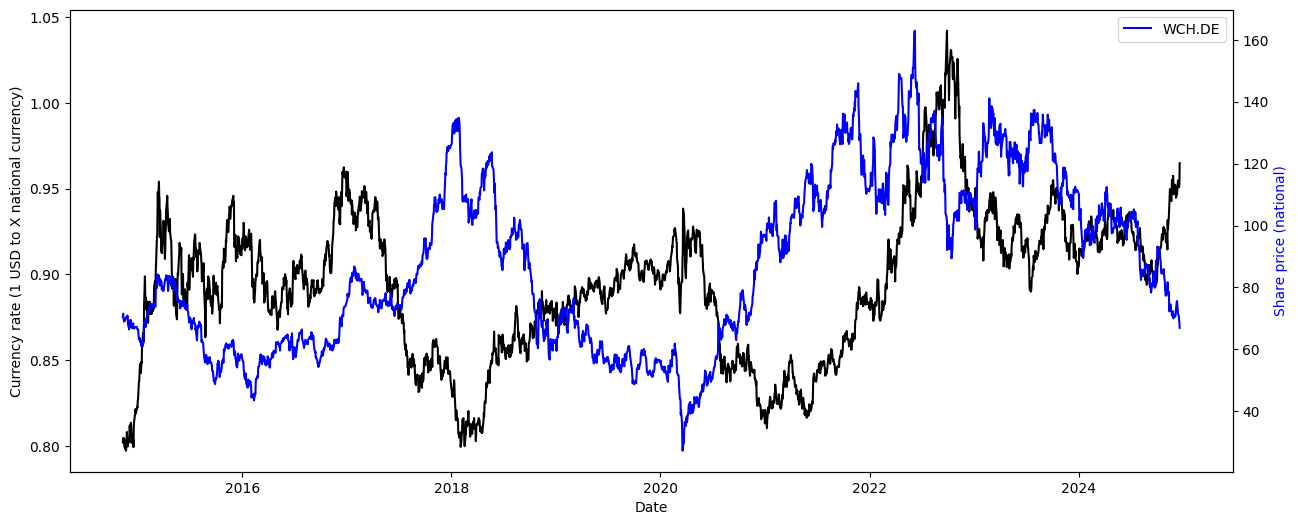

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

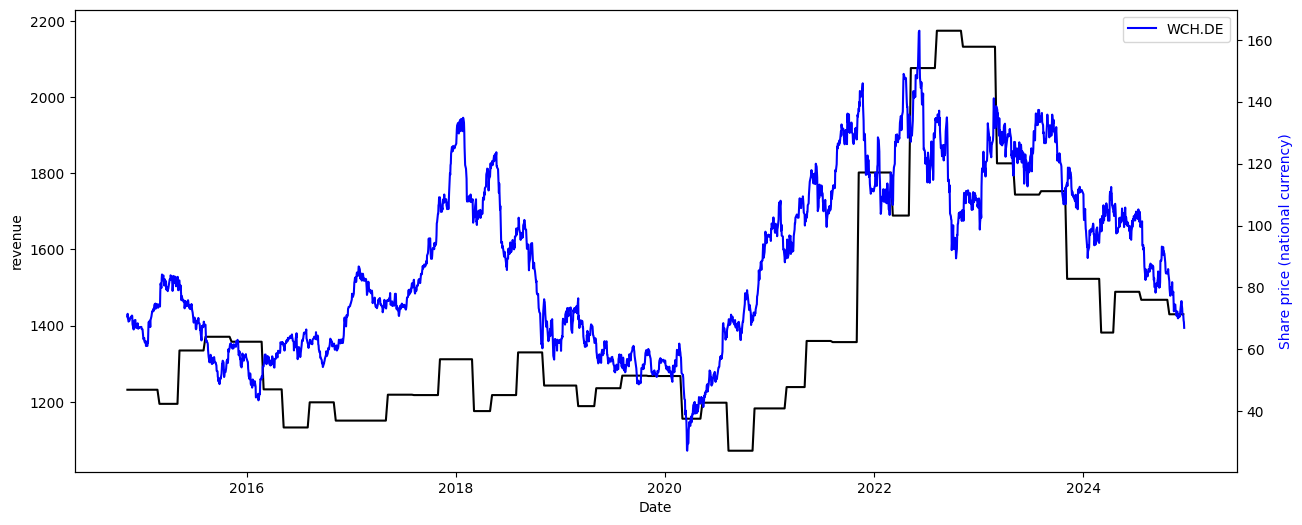

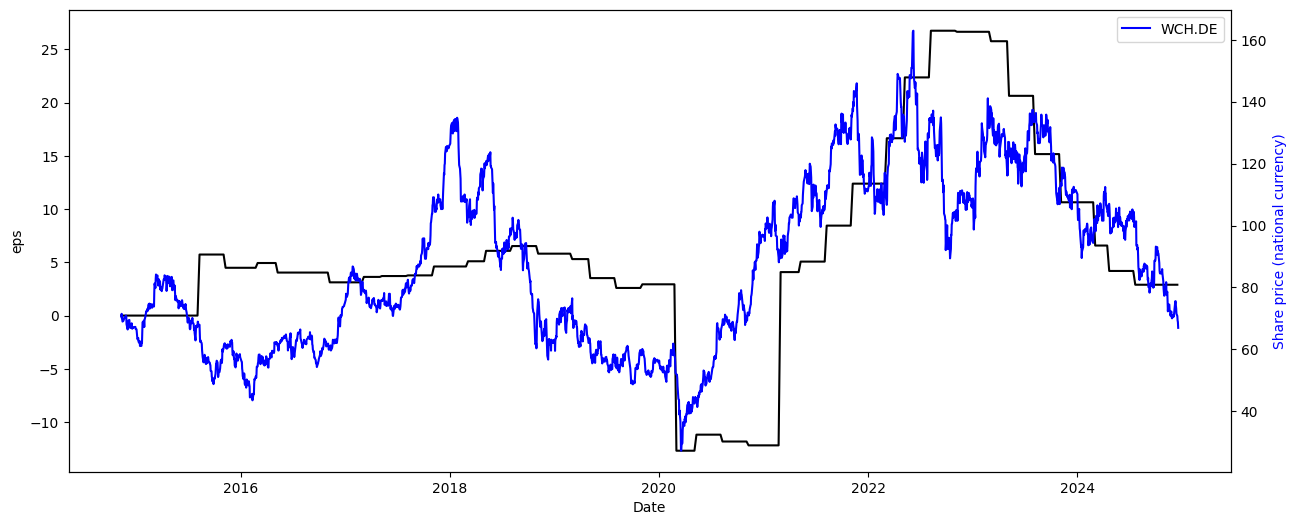

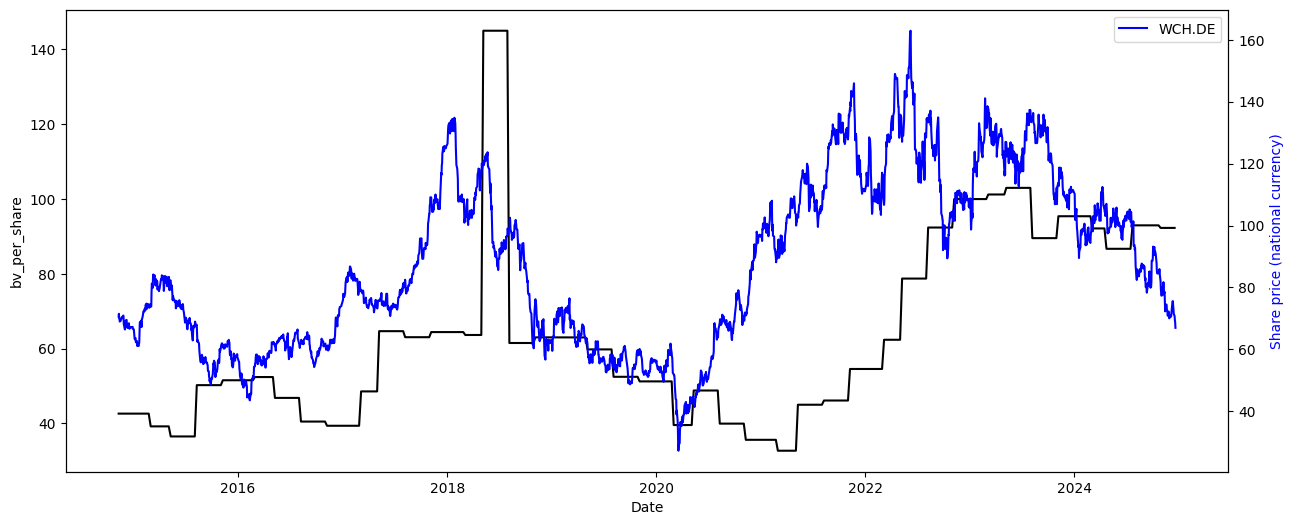

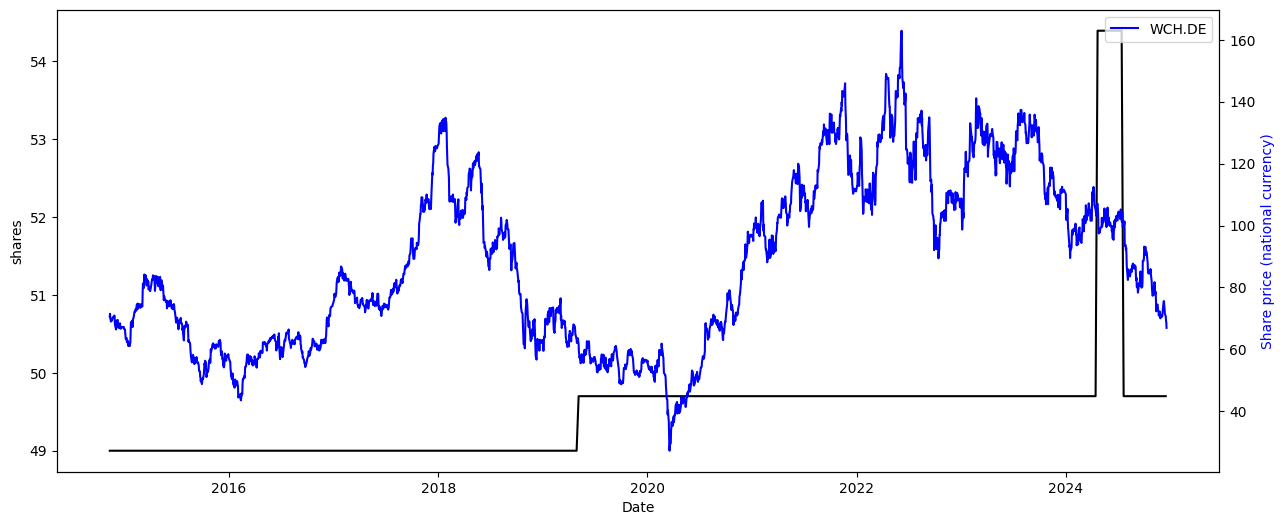

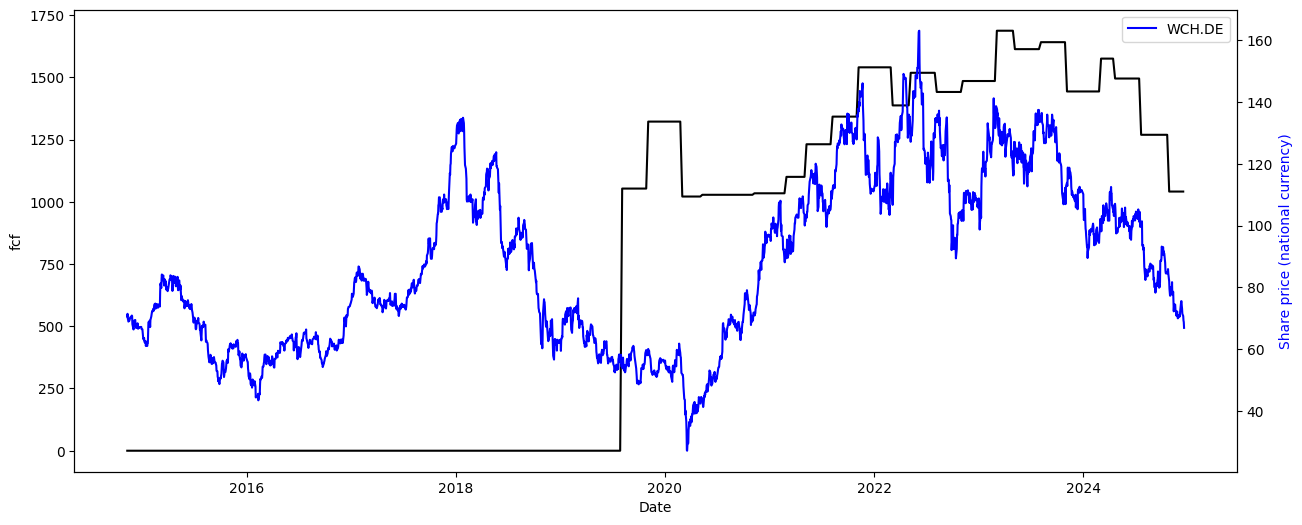

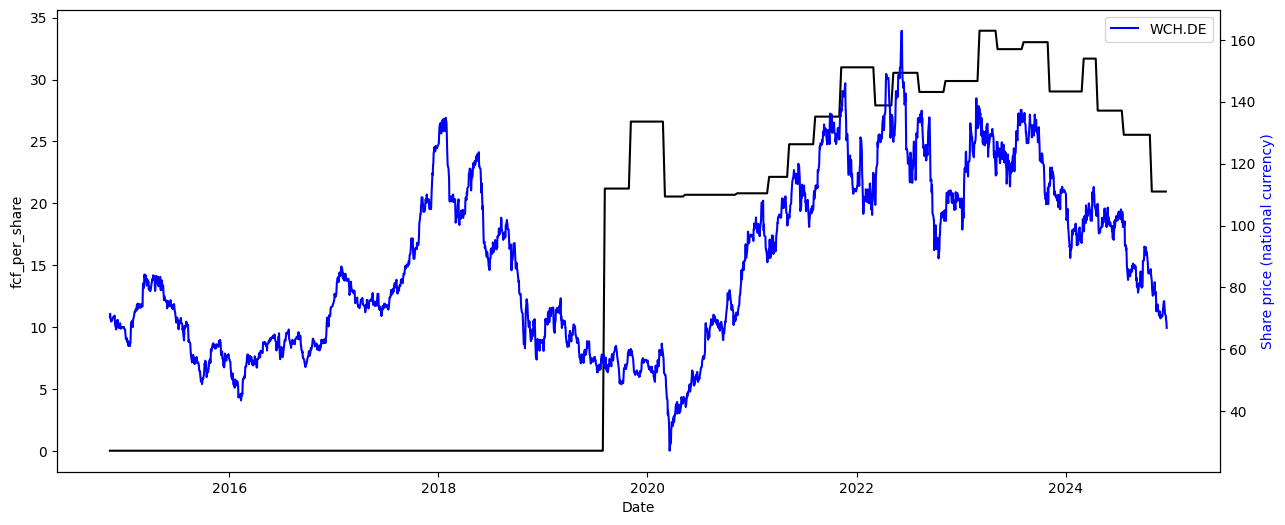

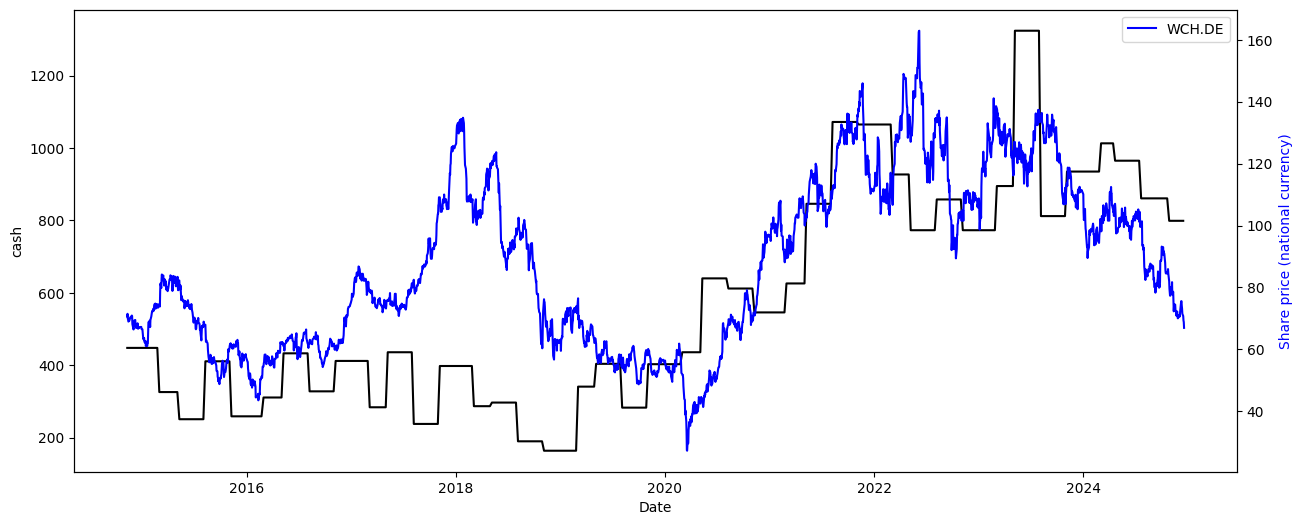

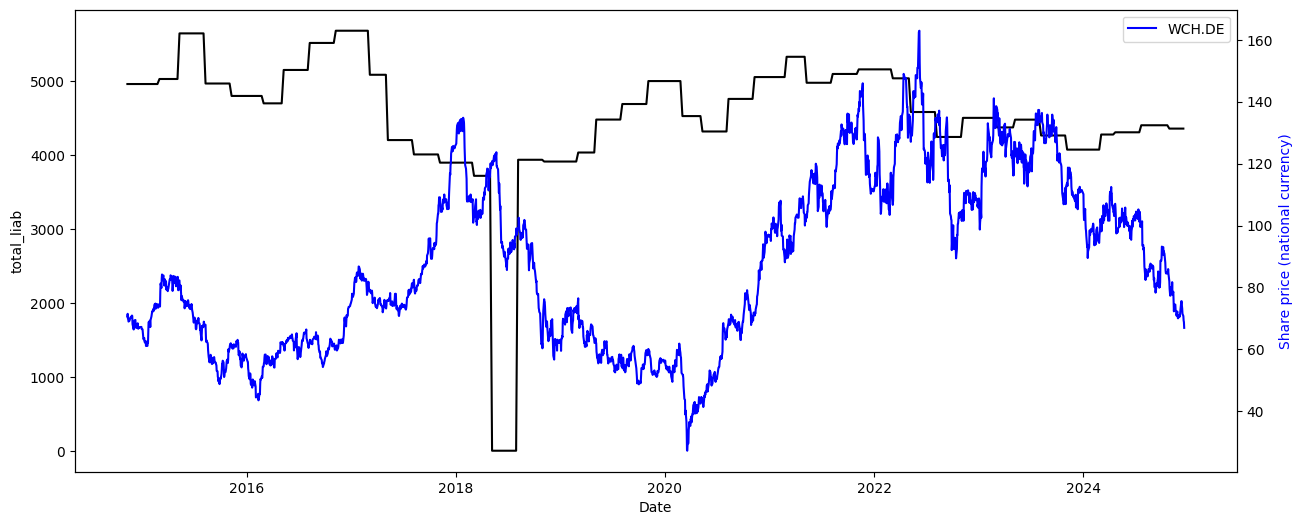

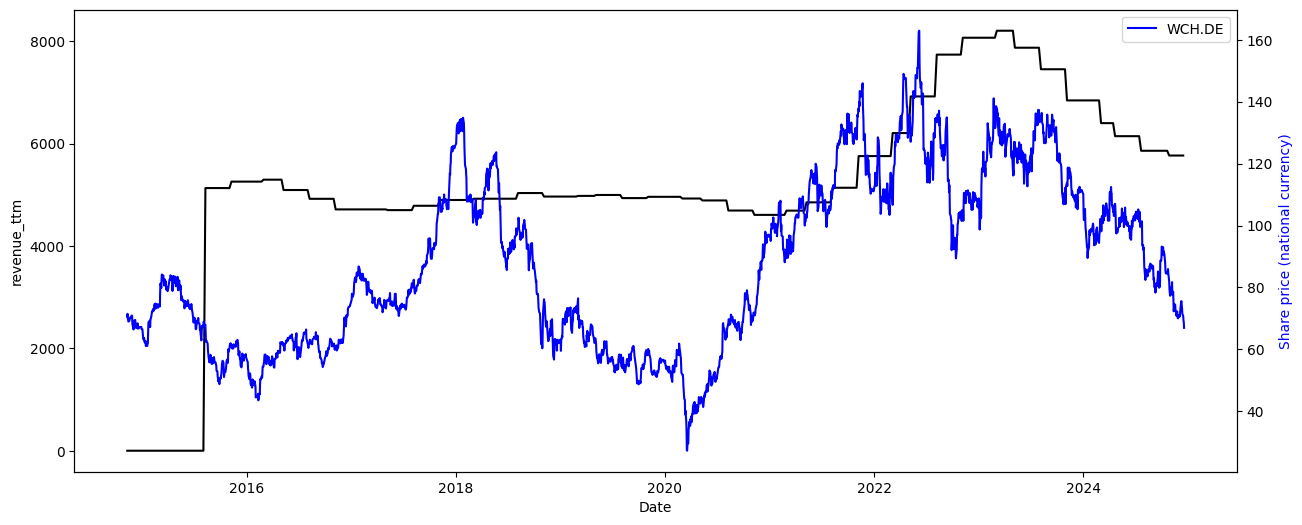

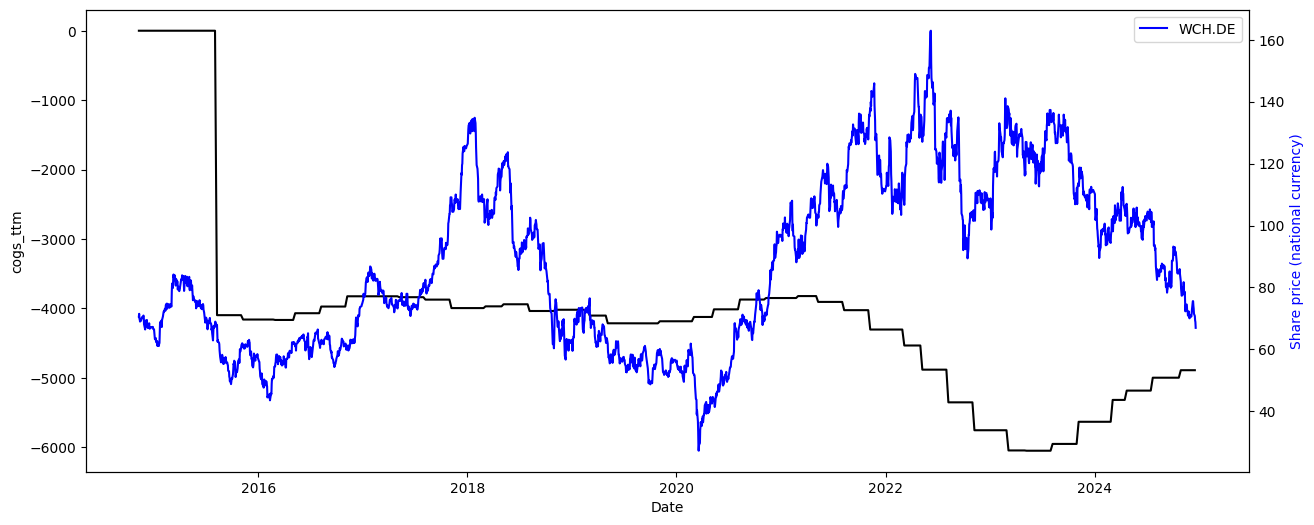

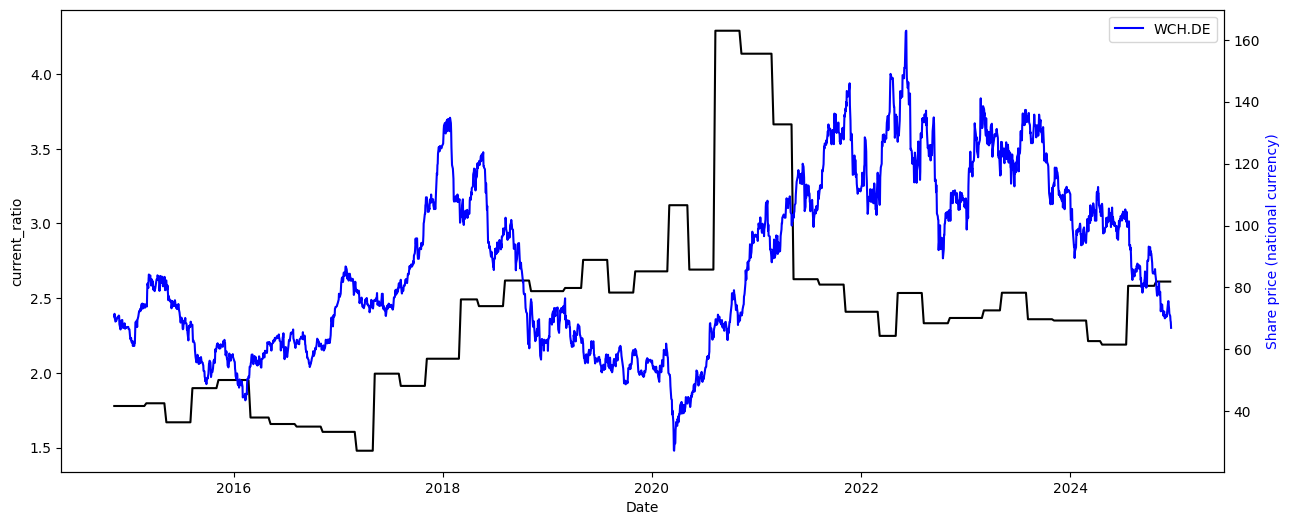

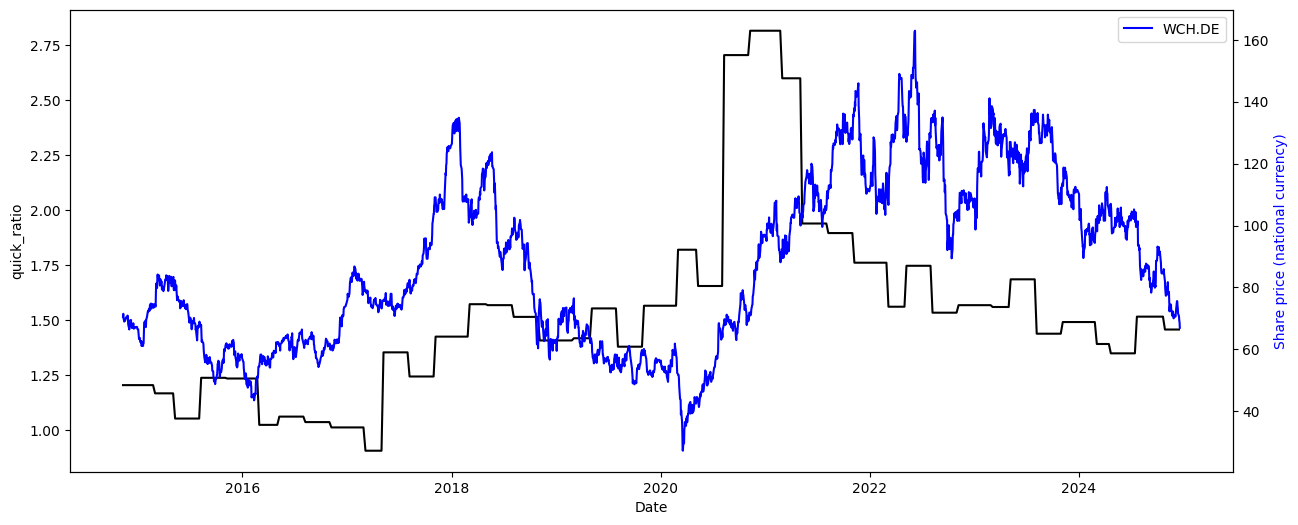

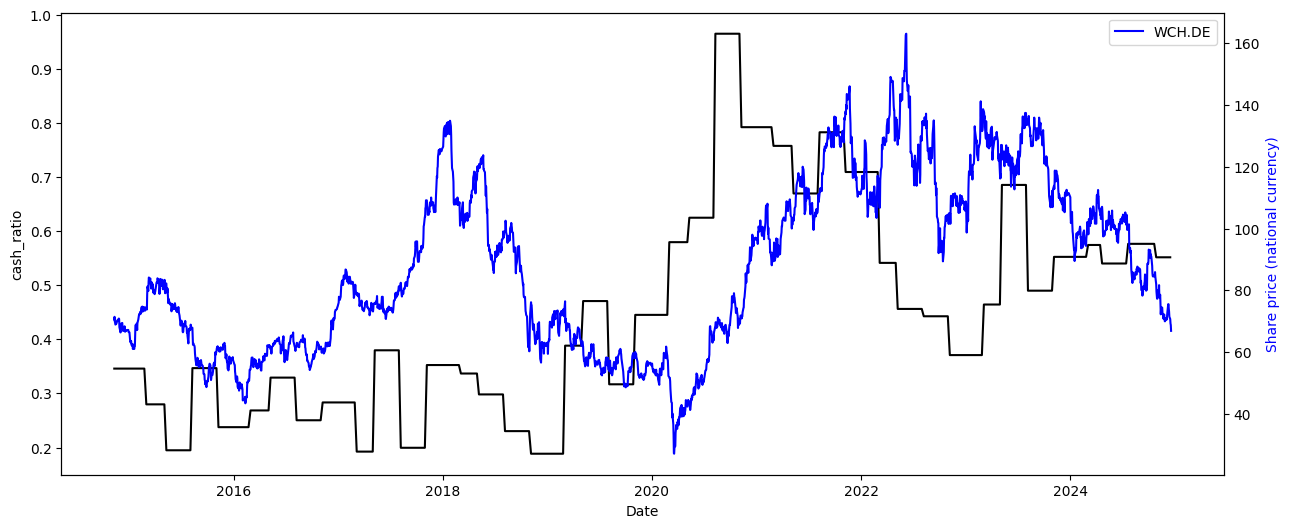

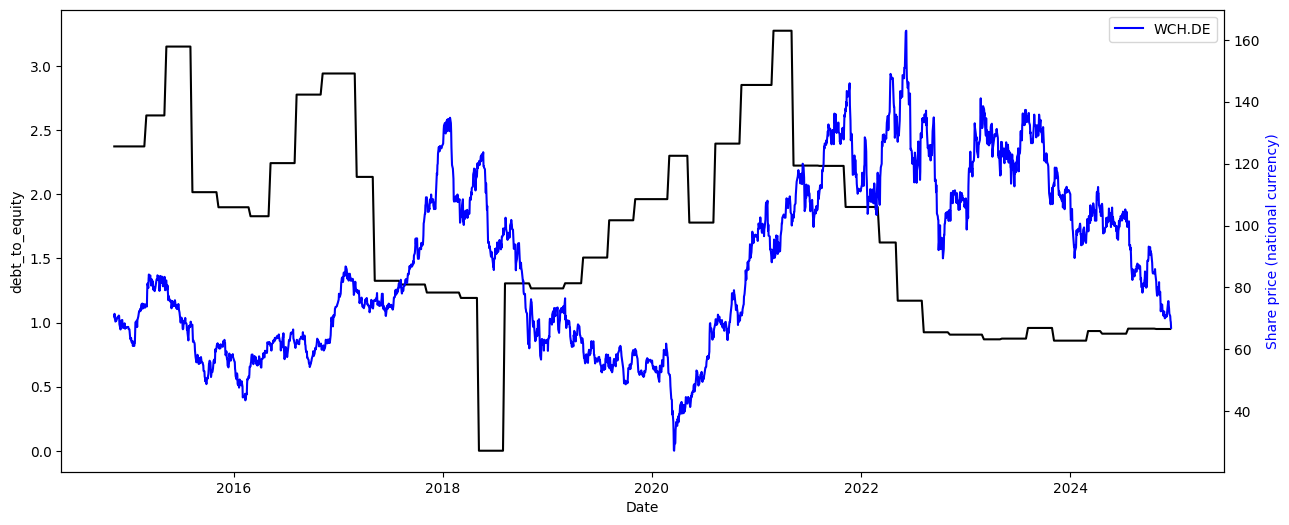

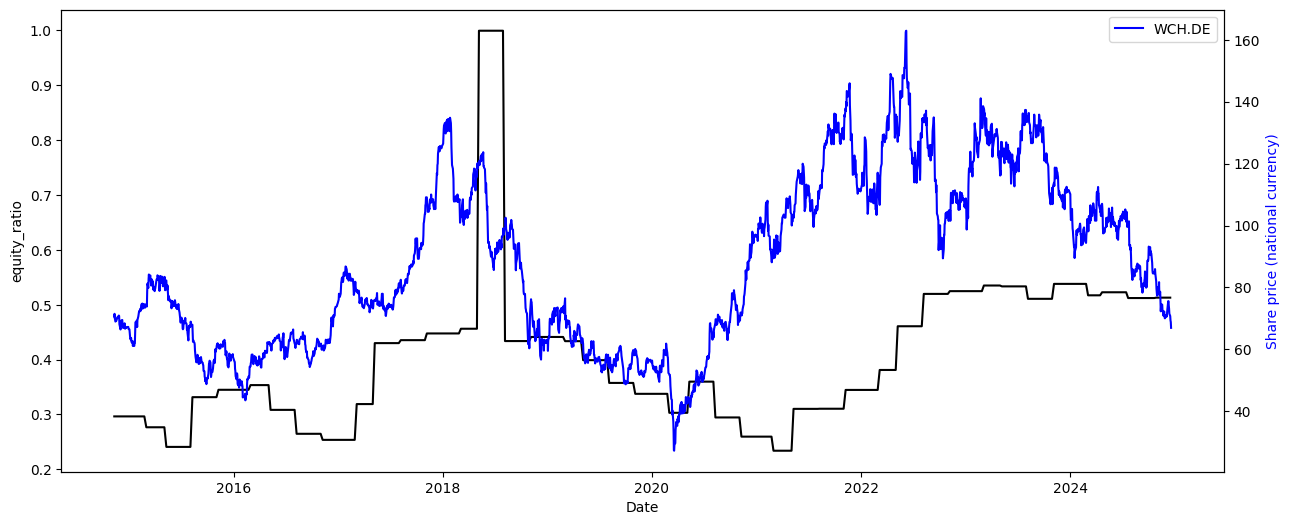

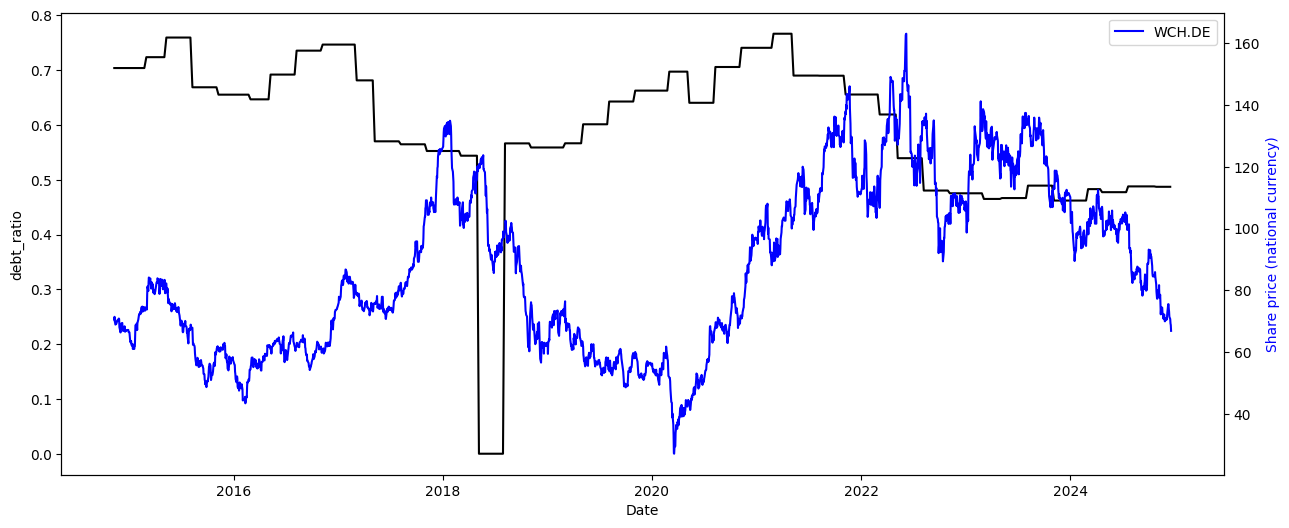

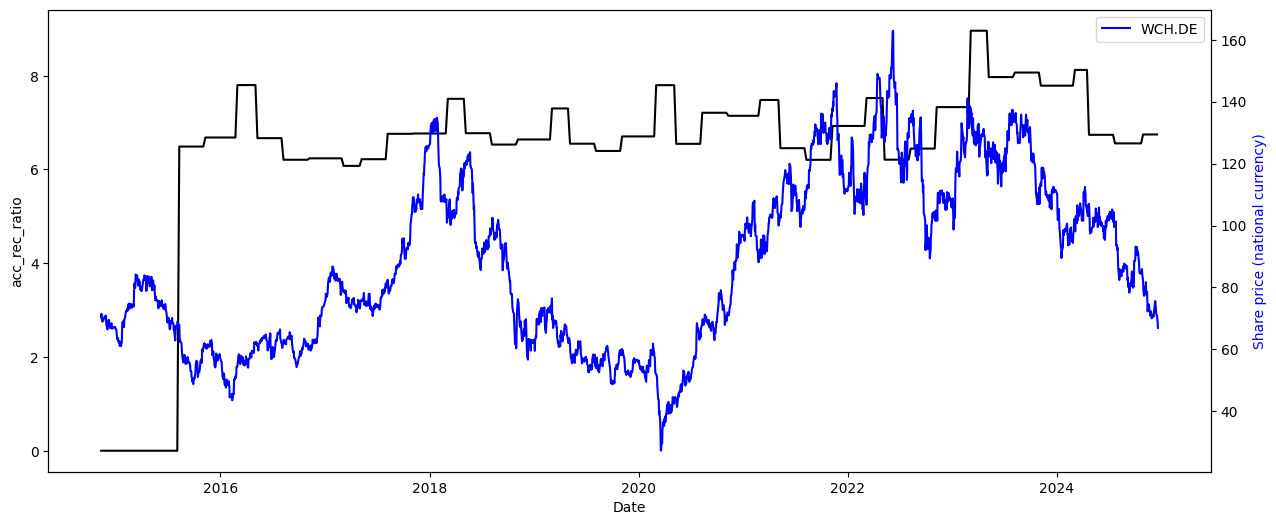

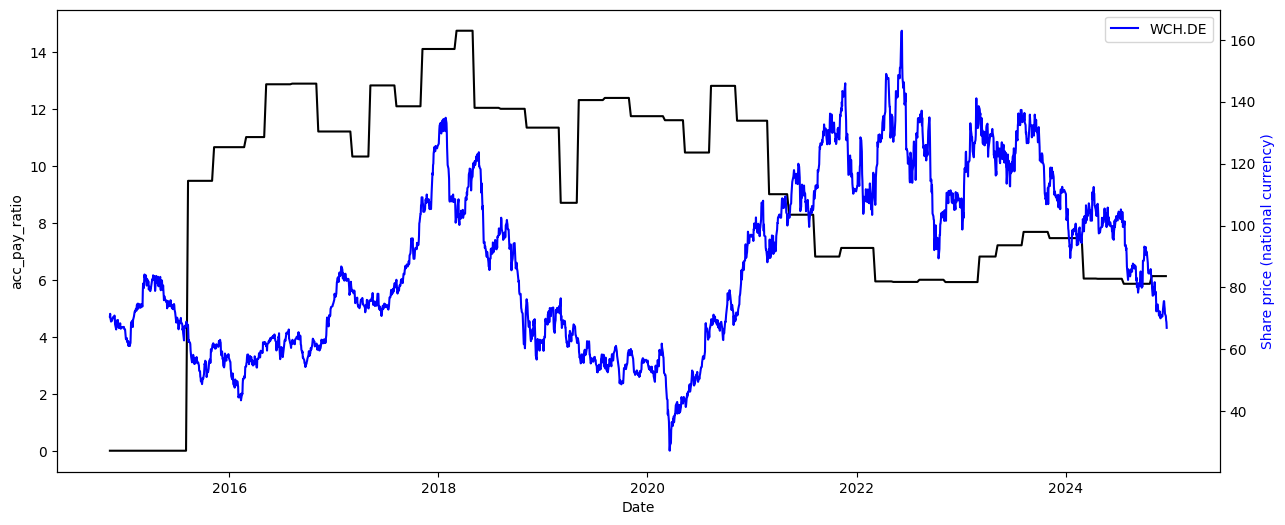

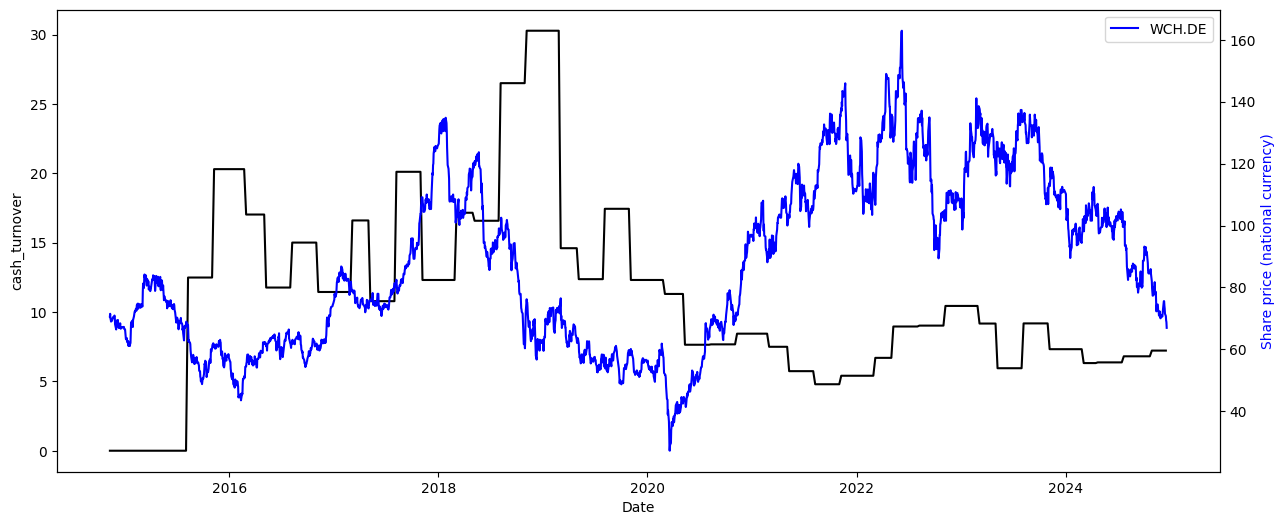

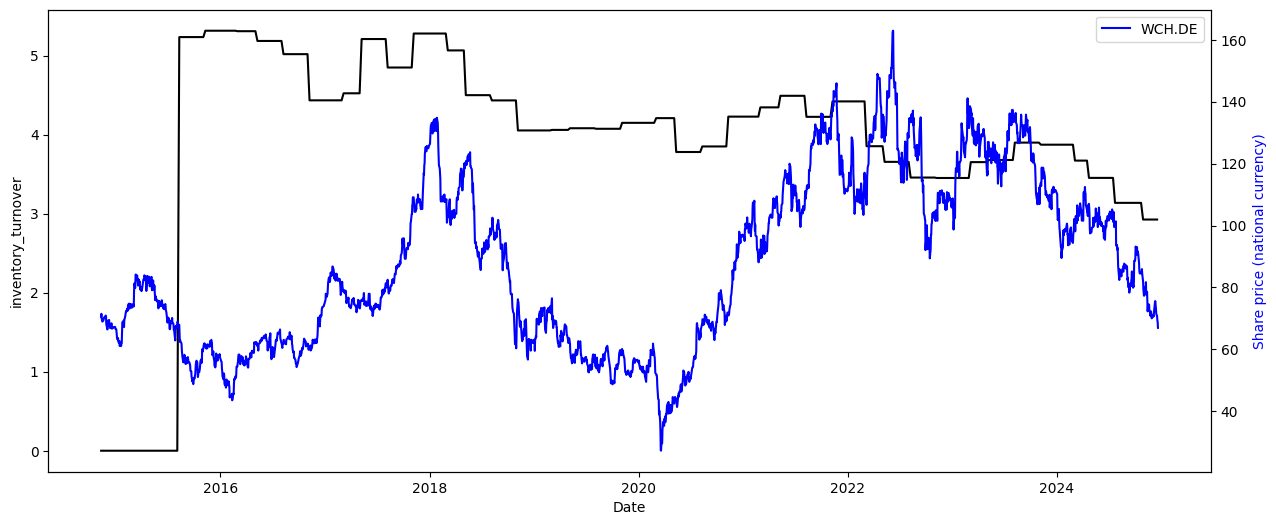

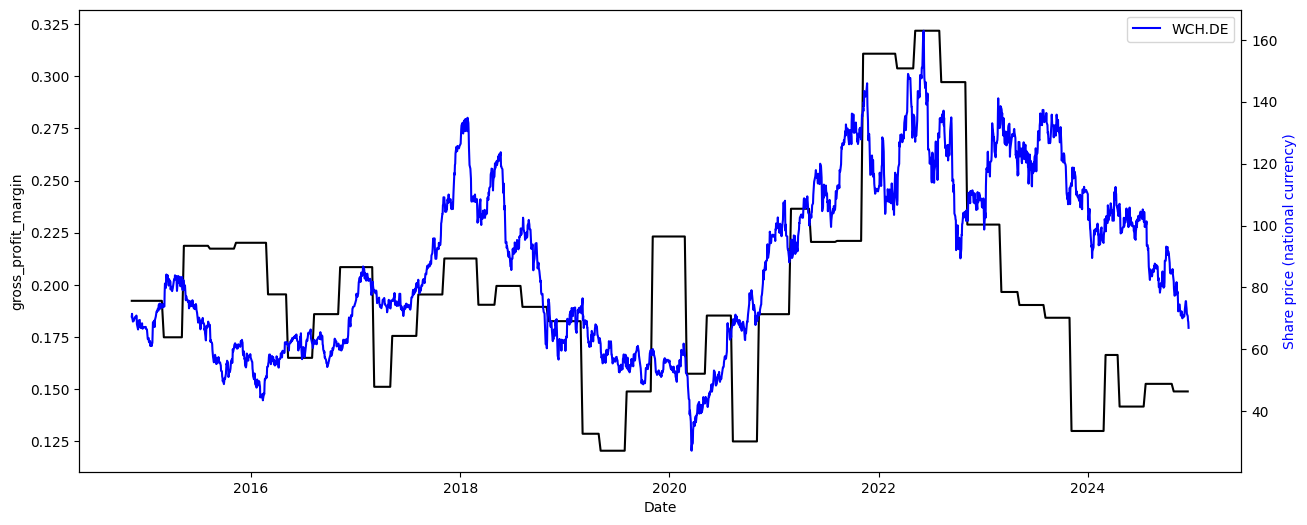

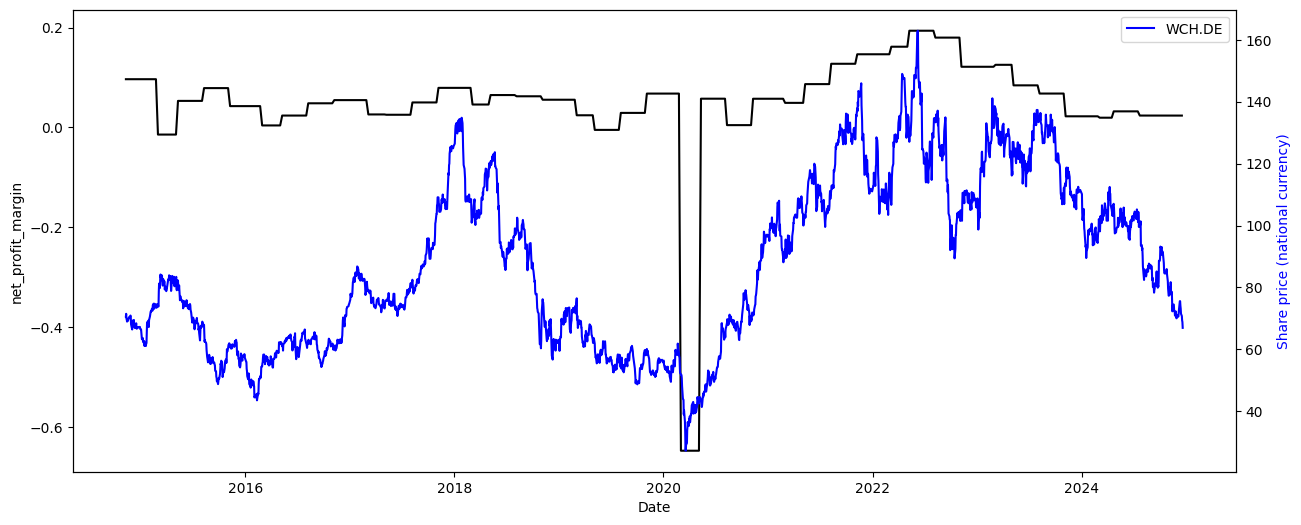

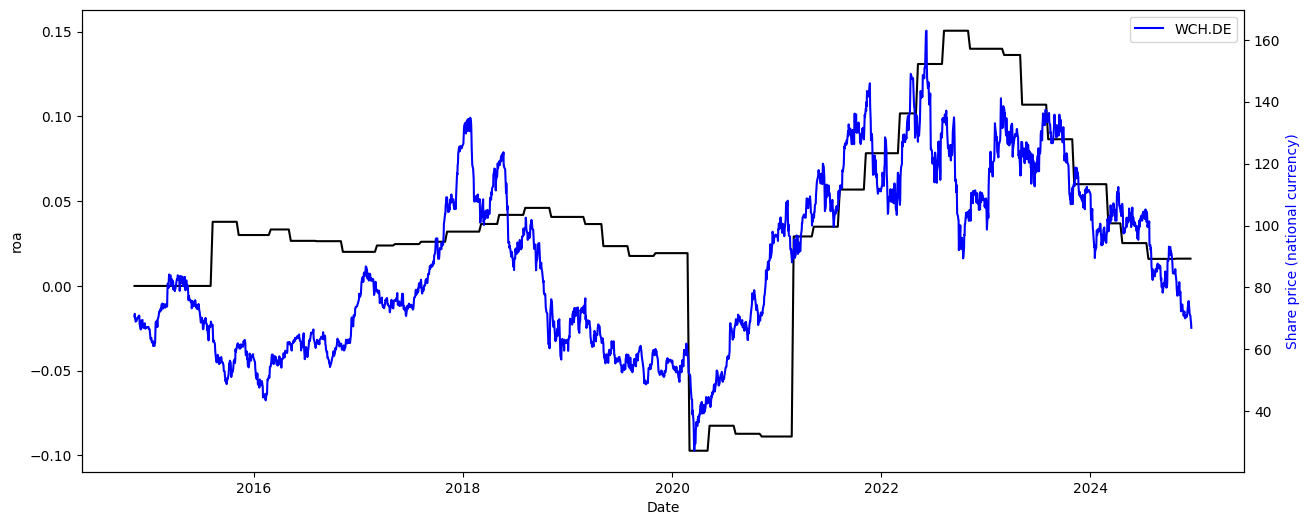

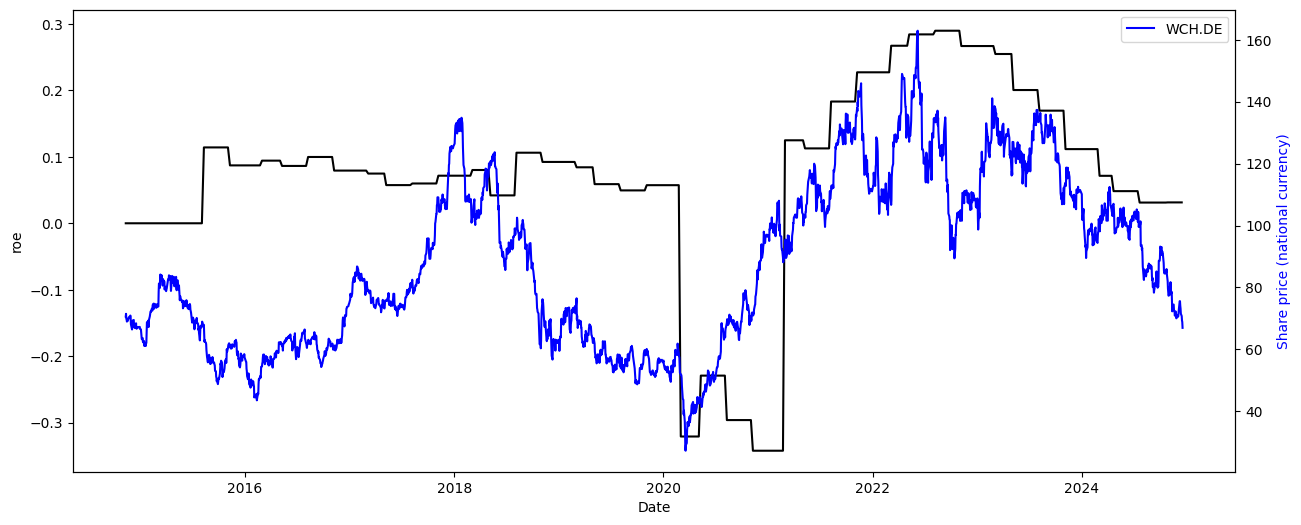

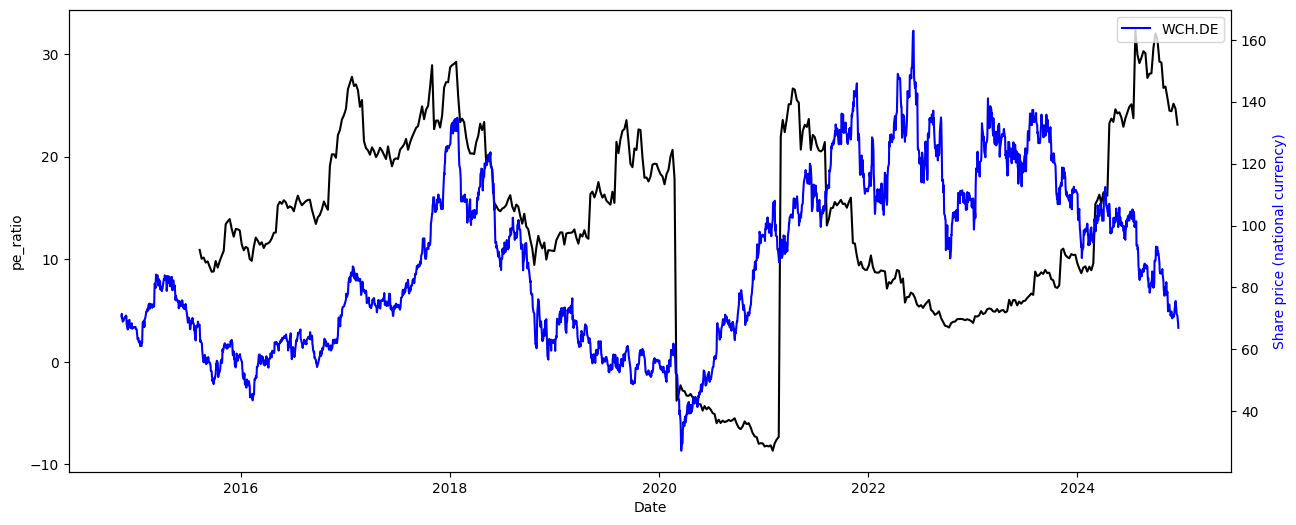

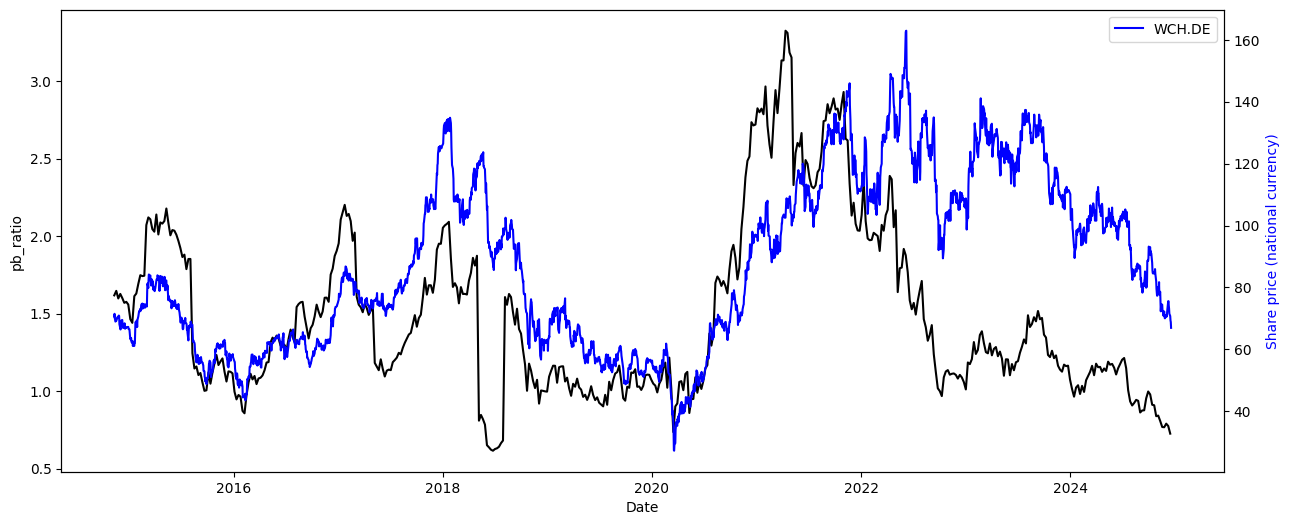

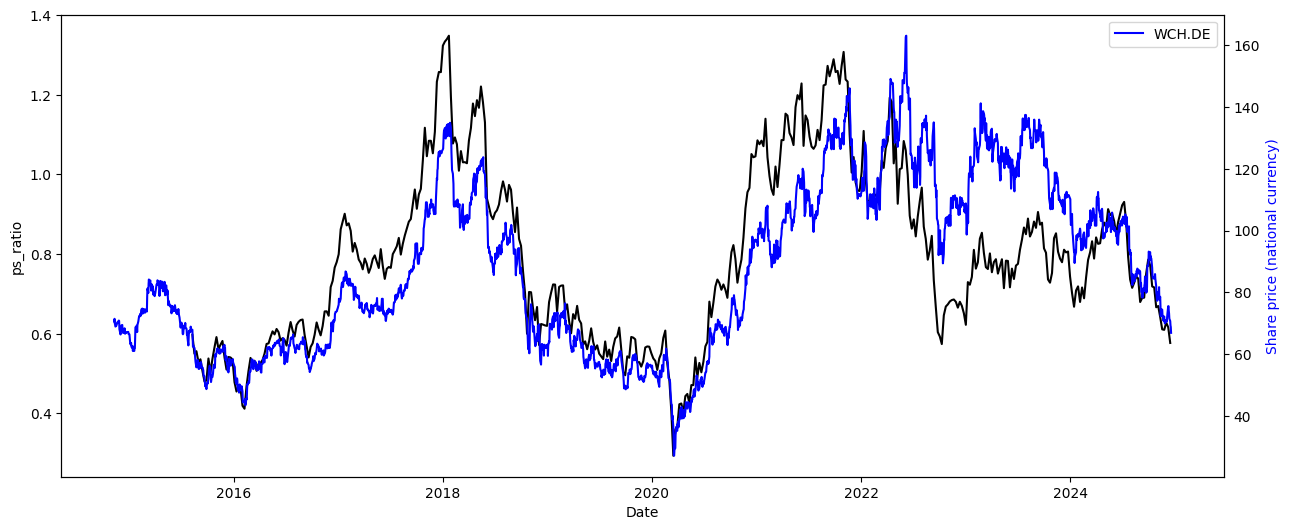

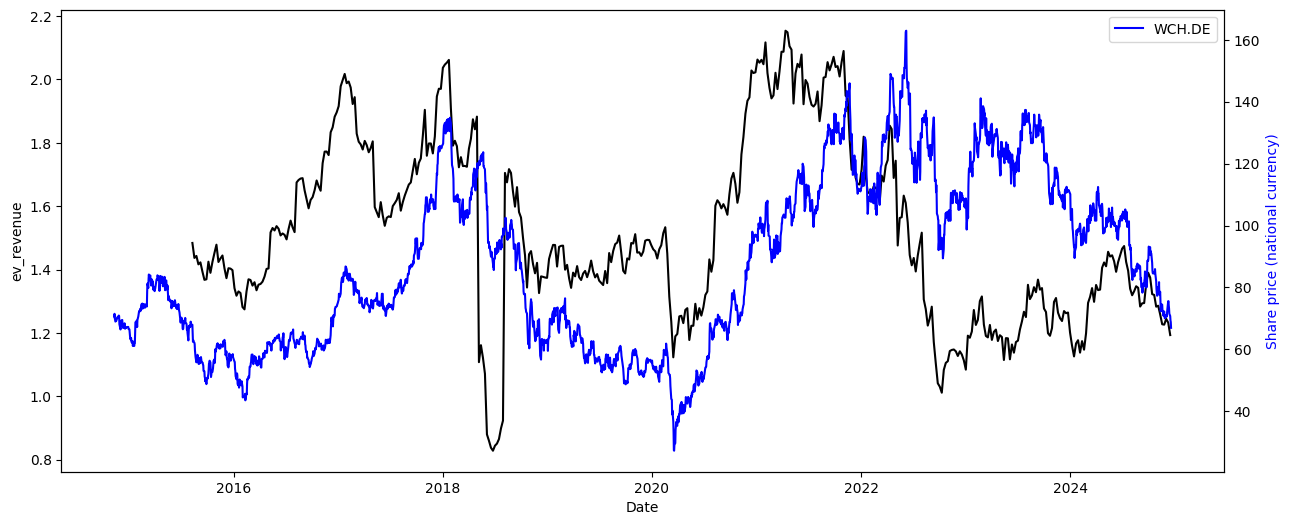

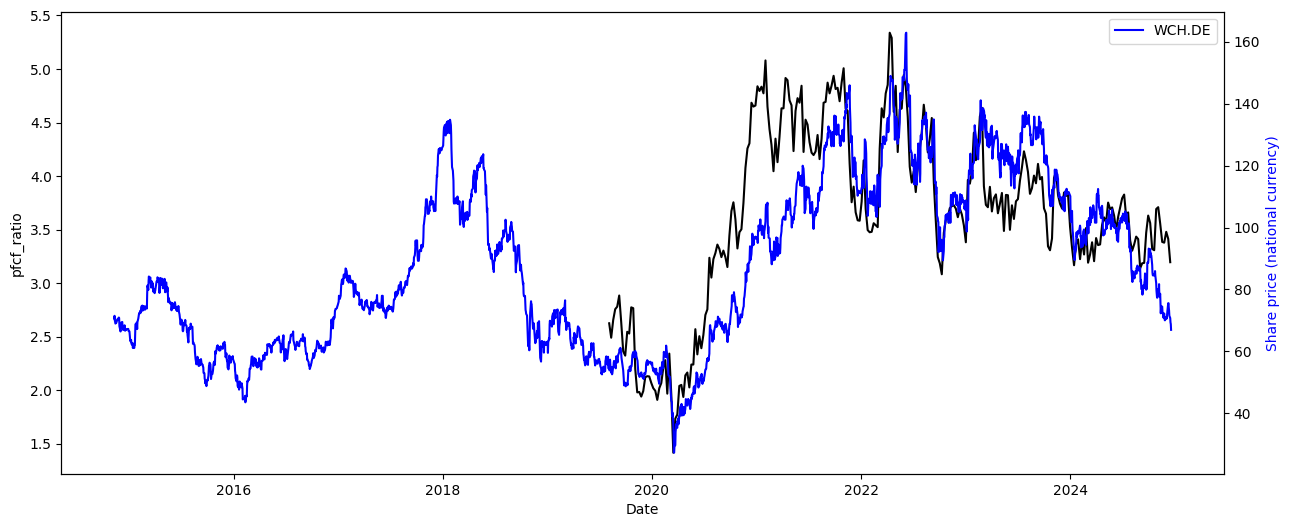

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

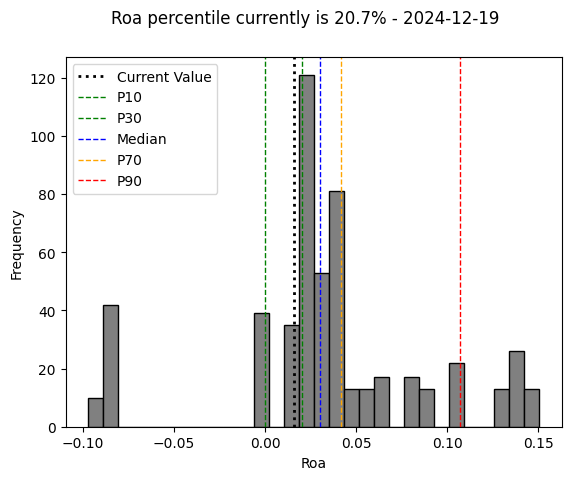

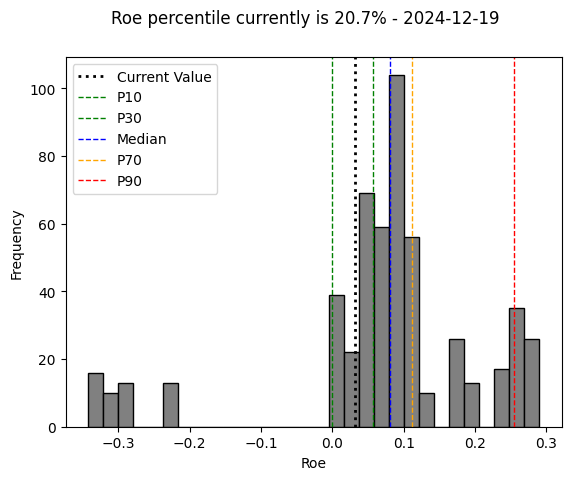

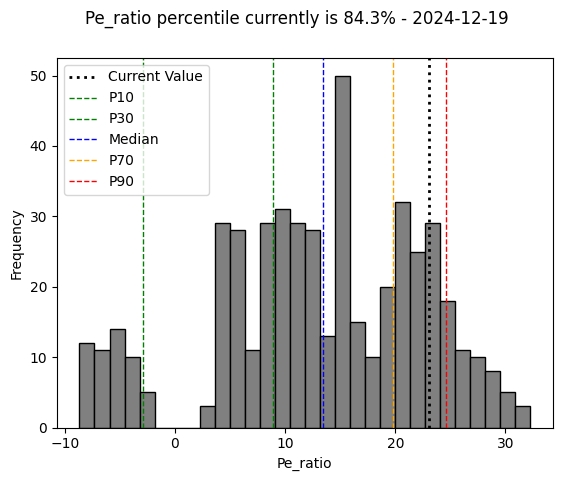

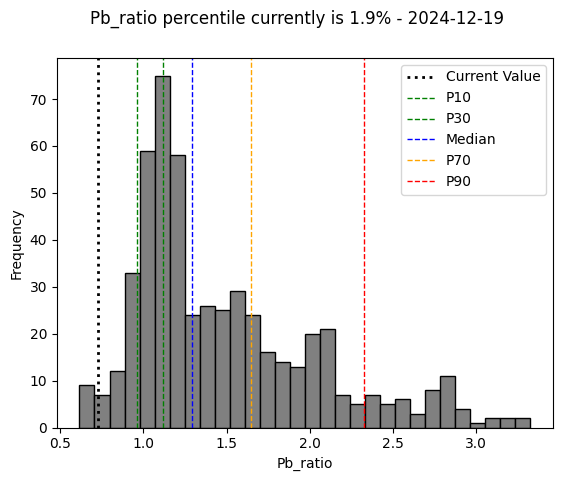

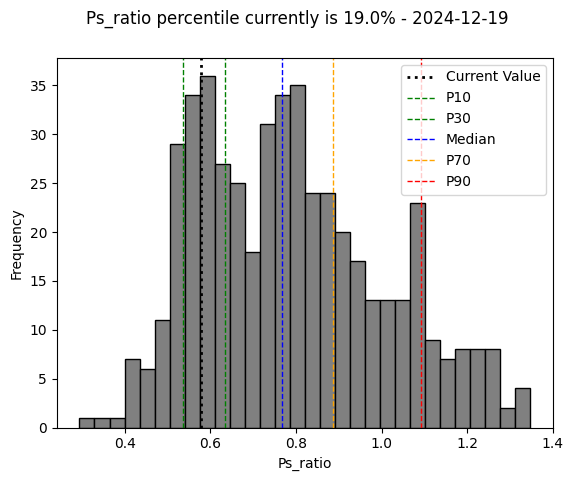

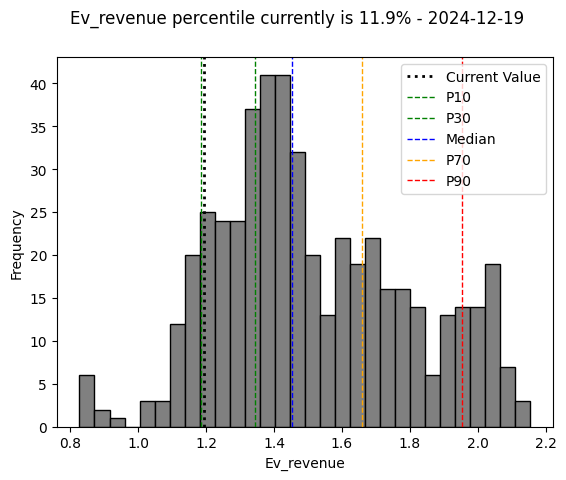

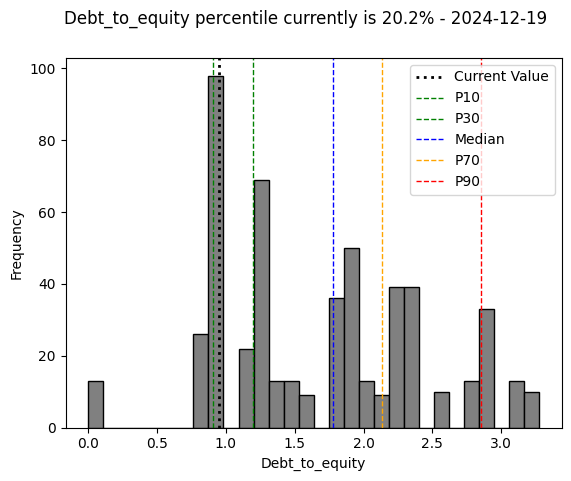

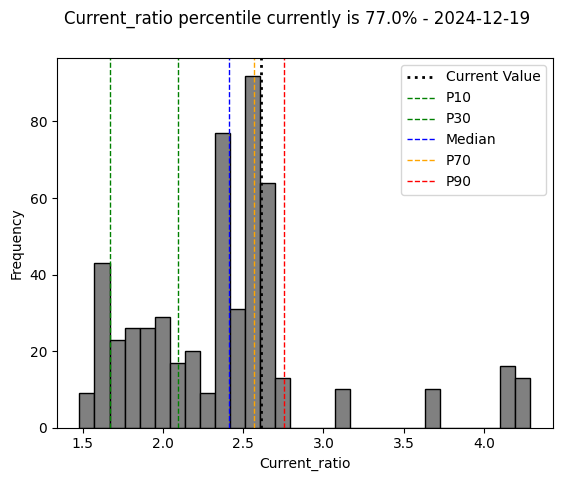

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.960172,0.151831,-0.110289,0.192496,-0.267512,-0.524557,-0.365749
roe,0.960172,1.000000,0.328357,-0.048300,0.193980,-0.133187,-0.396650,-0.491036
pe_ratio,0.151831,0.328357,1.000000,-0.026967,0.216593,0.257419,-0.088918,-0.490060
pb_ratio,-0.110289,-0.048300,-0.026967,1.000000,0.730709,0.869112,0.614329,0.252512
ps_ratio,0.192496,0.193980,0.216593,0.730709,1.000000,0.606633,-0.048356,0.157925
ev_revenue,-0.267512,-0.133187,0.257419,0.869112,0.606633,1.000000,0.684618,0.131282
debt_to_equity,-0.524557,-0.396650,-0.088918,0.614329,-0.048356,0.684618,1.000000,0.053951
current_ratio,-0.365749,-0.491036,-0.490060,0.252512,0.157925,0.131282,0.053951,1.000000


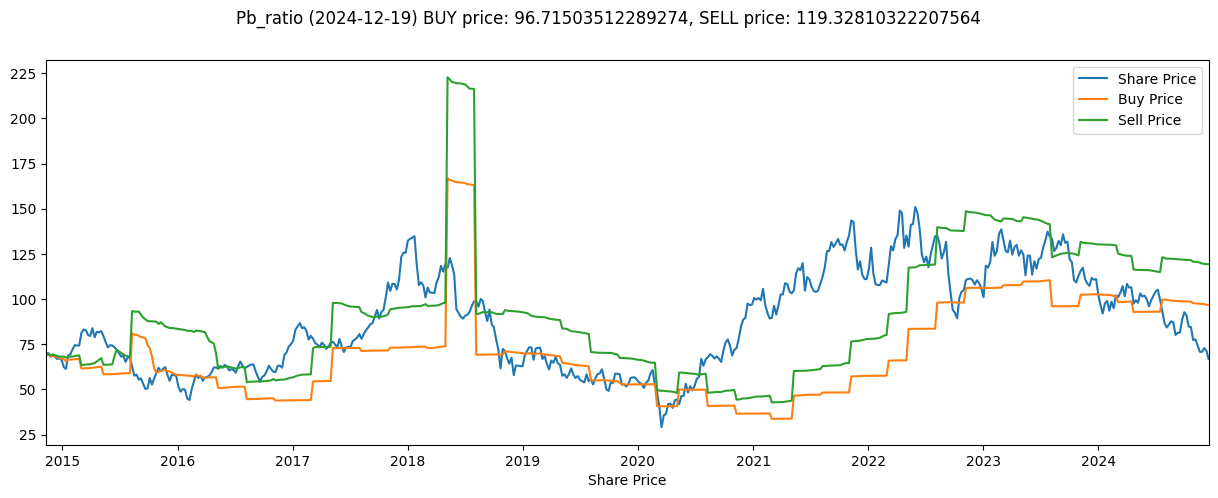

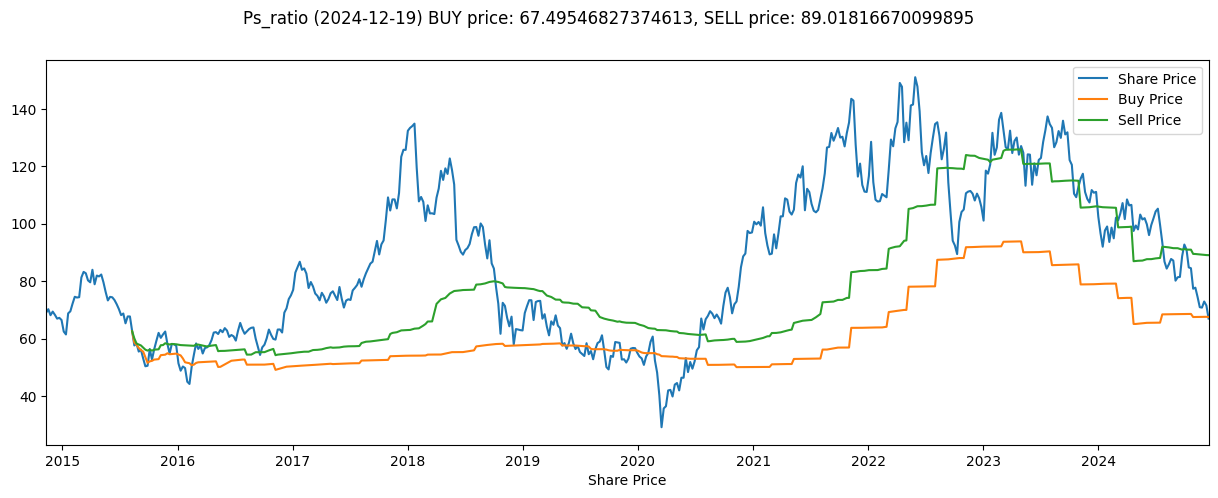

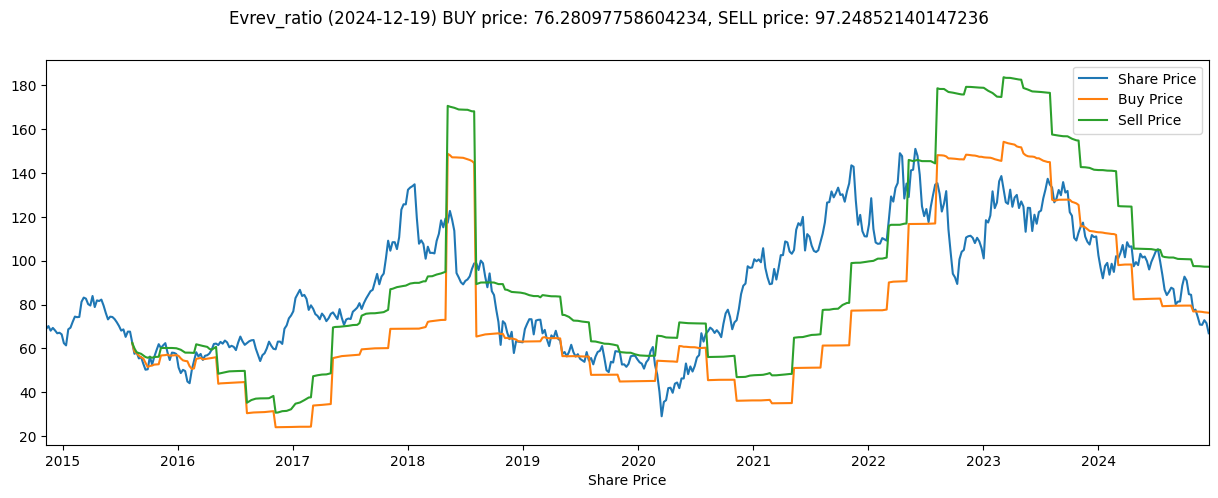

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)